In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward

In [3]:
S = 32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 8 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [4]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0)
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [5]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [6]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [7]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [8]:
hs_pt_half, n_pt_half, m_pt_half, _, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
hs_pt_half.dtype

torch.float16

In [9]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
hs_pt_bf16.dtype

torch.bfloat16

In [10]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")

====== Full -> Half ======
fw hs match: False, max diff: 0.02645564079284668
fw n match: False, max diff: 0.010812759399414062
fw m match: False, max diff: 0.006419777870178223
fw D match: False, max diff: 0.012081146240234375
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.15340876579284668
fw n match: False, max diff: 0.09692215919494629
fw m match: False, max diff: 0.05207604169845581
fw D match: False, max diff: 0.15224838256835938


In [11]:
(hs_pt_half.float() - hs_pt) #> 4.5e-3

tensor([[[[-8.2469e-04, -4.0293e-05,  3.9279e-05,  1.5646e-06, -2.2829e-05,  3.1918e-05, -8.4996e-05, -1.2887e-04],
          [ 1.0188e-03, -2.9069e-04, -3.5086e-04,  2.2091e-05,  3.9682e-05, -1.6275e-04, -1.6958e-04,  2.7680e-04],
          [-8.3047e-04,  4.6849e-05, -9.2024e-04,  2.5344e-04,  6.2296e-04,  8.5697e-05, -1.1201e-03,  1.1749e-03],
          [ 1.9765e-04,  3.4308e-04, -1.2231e-04,  1.2952e-04,  1.2159e-04,  2.1517e-05,  9.5367e-06,  1.0679e-03],
          [-5.8177e-04, -9.0837e-05,  2.7262e-04, -6.2329e-04,  7.4536e-05,  2.2885e-04, -1.9744e-04,  3.6255e-04],
          [ 2.5011e-04,  5.6922e-05,  2.8580e-04,  1.9385e-04,  2.0182e-04, -1.9410e-04,  3.6433e-04,  8.1182e-05],
          [ 3.7201e-04, -6.1180e-04, -5.3038e-04,  8.7488e-04,  3.0231e-03, -1.9970e-03, -3.1338e-04, -2.7442e-04],
          [-1.7107e-04,  3.5208e-04, -3.2121e-04,  1.9132e-04,  1.7822e-05, -2.6332e-04, -1.1712e-04, -2.6174e-04],
          [-3.2991e-04, -2.0562e-04, -8.4484e-04,  9.0355e-04, -2.1640e-

In [12]:
(hs_pt_bf16.float() - hs_pt) #> 0.018

tensor([[[[-2.7778e-03, -1.5051e-03,  7.7170e-04, -2.4258e-04, -2.0593e-04,  7.6434e-04, -8.4996e-05,  1.3360e-03],
          [-1.0700e-02,  1.9759e-04, -1.0672e-04, -5.2723e-04, -1.4342e-04,  2.2787e-03, -5.0524e-03,  2.7182e-03],
          [ 2.5875e-03, -1.4180e-03, -4.3195e-04,  4.9758e-04,  1.1112e-03,  1.4673e-04,  8.3303e-04,  3.6163e-03],
          [ 1.1742e-03,  1.3196e-03, -2.5637e-03, -1.3353e-03,  6.0987e-04,  1.9746e-03, -4.7874e-04, -1.2604e-02],
          [ 3.3245e-03, -9.0837e-05, -9.3594e-05, -4.5295e-03,  1.3563e-03, -2.5943e-04,  3.7088e-03,  3.0481e-03],
          [-6.6542e-04,  5.4520e-04,  2.8580e-04,  2.5488e-04, -2.7279e-03,  5.0038e-05, -2.3212e-03, -2.8503e-04],
          [-2.3834e-04,  3.2945e-03,  4.7186e-03,  2.3397e-03,  1.0836e-02,  4.8389e-03,  2.8604e-03, -7.6270e-04],
          [-7.9836e-03,  9.6294e-03,  6.2706e-03, -3.9286e-03, -9.2595e-03,  9.1361e-03,  5.7423e-03,  3.4614e-03],
          [ 6.0177e-03, -2.0367e-03,  2.0849e-03, -4.4675e-03, -9.6957e-

In [13]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(0.1534, device='cuda:0'), tensor(0.0073, device='cuda:0'))

### match directly

In [14]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [15]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [16]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [17]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")



Match against pt float32:
====== Full ======
fw hs match: True, max diff: 5.7220458984375e-06
fw n match: True, max diff: 7.152557373046875e-06
fw m match: True, max diff: 3.6954879760742188e-06
fw D match: True, max diff: 4.291534423828125e-06
====== Half ======
fw hs match: False, max diff: 3.483307361602783
fw n match: False, max diff: 0.985108494758606
fw m match: False, max diff: 1.3403302431106567
fw D match: False, max diff: 13.343843460083008
====== bfloat16 ======
fw hs match: False, max diff: 0.02412557601928711
fw n match: False, max diff: 0.010062456130981445
fw m match: False, max diff: 0.0052010416984558105
fw D match: False, max diff: 0.03386878967285156


float32, bfloat16, float16 hs diff:


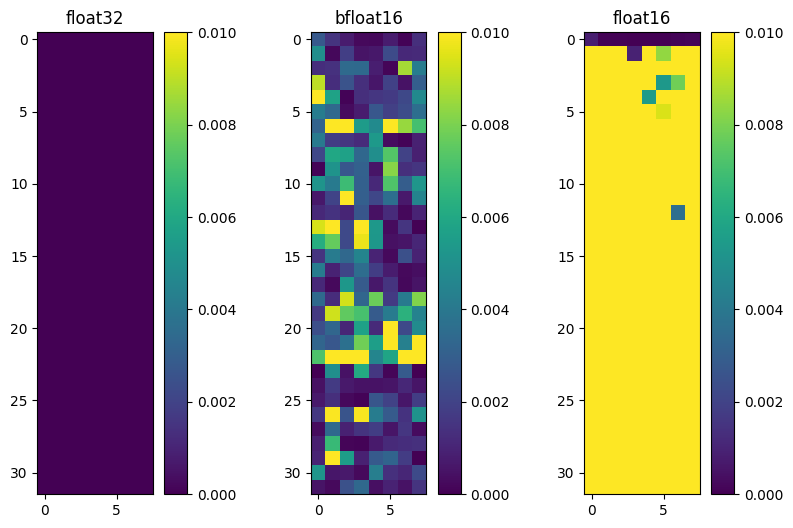

In [28]:
print(f"float32, bfloat16, float16 hs diff:")
vmin=0.0
vmax=1e-2
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 6), ncols=3)
pos1 = ax1.imshow(((hs_cu - hs_pt).abs()).squeeze().cpu().numpy(), vmin=vmin, vmax=vmax)
ax1.set_title("float32")
fig.colorbar(pos1, ax=ax1)
pos2 = ax2.imshow(((hs_cu_bf16 - hs_pt).abs()).squeeze().cpu().numpy(), vmin=vmin, vmax=vmax)
ax2.set_title("bfloat16")
fig.colorbar(pos2, ax=ax2)
pos3 = ax3.imshow(((hs_cu_half - hs_pt).abs()).squeeze().cpu().numpy(), vmin=vmin, vmax=vmax)
ax3.set_title("float16")
fig.colorbar(pos3, ax=ax3)

float32 hs diff:


(tensor([[[[-2.5441e+00,  7.1635e-01,  4.9337e-01, -1.2671e-01, -1.0136e-01,  4.0353e-01, -9.0226e-01, -8.0993e-01],
           [-2.2862e+00,  6.4824e-01,  3.7120e-01, -1.2398e-01, -6.3333e-02,  3.7858e-01, -9.9495e-01, -6.0037e-01],
           [-6.0024e-01,  2.7681e-01, -4.9371e-01,  3.6669e-01,  4.5201e-01,  1.0728e-01, -1.0555e+00,  5.2373e-01],
           [ 1.4676e+00, -1.2904e+00,  8.6194e-01, -6.4320e-01,  9.3298e-01, -6.3869e-01, -7.2218e-01,  2.2001e+00],
           [ 3.8925e-01, -2.7335e-01,  2.3252e-01,  4.0492e-01,  1.2218e-01, -2.6341e-01, -3.4160e-01,  2.5086e-01],
           [ 1.0809e-01, -5.8648e-01, -7.0732e-01, -1.0621e-01, -1.0207e+00,  1.7768e-01, -3.6291e-01, -1.5304e-01],
           [ 2.2973e-01, -2.3181e-01, -1.1165e-01,  9.3125e-01,  2.7548e+00, -1.9033e+00, -6.4628e-02, -6.6721e-01],
           [-5.9358e-01,  7.6381e-01,  1.4412e-01,  5.0315e-02, -7.0168e-01,  1.3540e-01,  2.9504e-01, -6.2543e-02],
           [ 8.9242e-01, -1.6984e-01,  1.1698e+00, -9.5256e-01, 

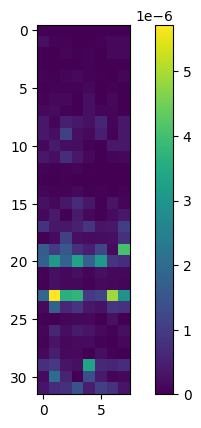

In [20]:
print(f"float32 hs diff:")
fig = plt.imshow(((hs_cu - hs_pt).abs()).squeeze().cpu().numpy())
plt.colorbar(fig)
hs_pt, hs_cu, (hs_cu - hs_pt)

float16 hs diff:


(tensor([[[[-2.5441e+00,  7.1635e-01,  4.9337e-01, -1.2671e-01, -1.0136e-01,  4.0353e-01, -9.0226e-01, -8.0993e-01],
           [-2.2862e+00,  6.4824e-01,  3.7120e-01, -1.2398e-01, -6.3333e-02,  3.7858e-01, -9.9495e-01, -6.0037e-01],
           [-6.0024e-01,  2.7681e-01, -4.9371e-01,  3.6669e-01,  4.5201e-01,  1.0728e-01, -1.0555e+00,  5.2373e-01],
           [ 1.4676e+00, -1.2904e+00,  8.6194e-01, -6.4320e-01,  9.3298e-01, -6.3869e-01, -7.2218e-01,  2.2001e+00],
           [ 3.8925e-01, -2.7335e-01,  2.3252e-01,  4.0492e-01,  1.2218e-01, -2.6341e-01, -3.4160e-01,  2.5086e-01],
           [ 1.0809e-01, -5.8648e-01, -7.0732e-01, -1.0621e-01, -1.0207e+00,  1.7768e-01, -3.6291e-01, -1.5304e-01],
           [ 2.2973e-01, -2.3181e-01, -1.1165e-01,  9.3125e-01,  2.7548e+00, -1.9033e+00, -6.4628e-02, -6.6721e-01],
           [-5.9358e-01,  7.6381e-01,  1.4412e-01,  5.0315e-02, -7.0168e-01,  1.3540e-01,  2.9504e-01, -6.2543e-02],
           [ 8.9242e-01, -1.6984e-01,  1.1698e+00, -9.5256e-01, 

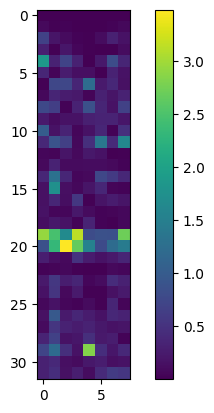

In [18]:
print(f"float16 hs diff:")
fig = plt.imshow(((hs_cu_half - hs_pt).abs()).squeeze().cpu().numpy())
plt.colorbar(fig)
hs_pt, hs_cu_half, (hs_cu_half - hs_pt)

bfloat16 hs diff:


(tensor([[[[-2.5441e+00,  7.1635e-01,  4.9337e-01, -1.2671e-01, -1.0136e-01,  4.0353e-01, -9.0226e-01, -8.0993e-01],
           [-2.2862e+00,  6.4824e-01,  3.7120e-01, -1.2398e-01, -6.3333e-02,  3.7858e-01, -9.9495e-01, -6.0037e-01],
           [-6.0024e-01,  2.7681e-01, -4.9371e-01,  3.6669e-01,  4.5201e-01,  1.0728e-01, -1.0555e+00,  5.2373e-01],
           [ 1.4676e+00, -1.2904e+00,  8.6194e-01, -6.4320e-01,  9.3298e-01, -6.3869e-01, -7.2218e-01,  2.2001e+00],
           [ 3.8925e-01, -2.7335e-01,  2.3252e-01,  4.0492e-01,  1.2218e-01, -2.6341e-01, -3.4160e-01,  2.5086e-01],
           [ 1.0809e-01, -5.8648e-01, -7.0732e-01, -1.0621e-01, -1.0207e+00,  1.7768e-01, -3.6291e-01, -1.5304e-01],
           [ 2.2973e-01, -2.3181e-01, -1.1165e-01,  9.3125e-01,  2.7548e+00, -1.9033e+00, -6.4628e-02, -6.6721e-01],
           [-5.9358e-01,  7.6381e-01,  1.4412e-01,  5.0315e-02, -7.0168e-01,  1.3540e-01,  2.9504e-01, -6.2543e-02],
           [ 8.9242e-01, -1.6984e-01,  1.1698e+00, -9.5256e-01, 

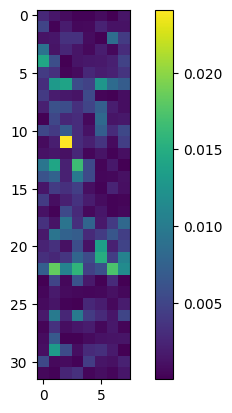

In [19]:
print(f"bfloat16 hs diff:")
fig = plt.imshow(((hs_cu_bf16 - hs_pt).abs()).squeeze().cpu().numpy())
plt.colorbar(fig)
hs_pt, hs_cu_bf16, (hs_cu_bf16 - hs_pt)